Some tests and exploration of the [Geopandas](https://geopandas.org/) and [Folium](https://python-visualization.github.io/folium/) packages for GIS.

General conclusions on the process:
- Projections are painful...
- Geopandas is super well constructed: does a great job of leveraging, but not overwhelming the pandas infrastructure.
- Geopandas and Folium both lack documentation and examples.

## IMPORTS

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.style as style
import pandas as pd
import geopandas as gpd
import libpysal as lp
import esda
import numpy as np
%matplotlib inline

## LOAD DATASETS

In [2]:
countries_url = "https://github.com/nvkelso/natural-earth-vector/raw/master/geojson/ne_10m_admin_0_countries.geojson"
cities_url = "https://github.com/nvkelso/natural-earth-vector/raw/master/geojson/ne_10m_populated_places_simple.geojson"
rivers_url = "https://github.com/nvkelso/natural-earth-vector/raw/master/geojson/ne_10m_rivers_lake_centerlines.geojson"

countries = gpd.read_file(countries_url)
cities = gpd.read_file(cities_url)
bodies_of_water = gpd.read_file(rivers_url)

In [3]:
# Verify consistent projections
cities.crs == countries.crs == bodies_of_water.crs

True

In [4]:
rivers = bodies_of_water.loc[bodies_of_water.featurecla=='River']

In [5]:
capitals = cities.loc[cities.featurecla=='Admin-0 capital']

## PLOT ALL DATA

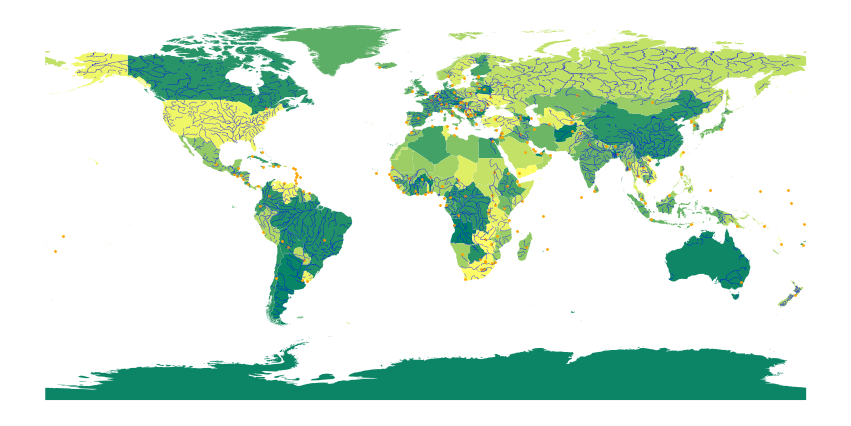

In [6]:
ax = countries.plot(cmap="summer", figsize=(15,15))
ax.set_axis_off()
capitals.plot(ax=ax, color='orange', markersize=3)
rivers.plot(ax=ax, color="blue", linewidth=.4, alpha=.7)

In [7]:
countries.rename(columns={"NAME": 'name'}, inplace=True)

In [8]:
belgium = countries.loc[countries.name=='Belgium', 'geometry'].squeeze()
germany = countries.loc[countries.name=='Germany', 'geometry'].squeeze()

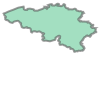

In [9]:
belgium

In [10]:
brussels = capitals.loc[capitals.name == 'Brussels', 'geometry'].squeeze()
berlin = capitals.loc[capitals.name == 'Berlin', 'geometry'].squeeze()

In [11]:
from shapely.geometry import LineString
line = LineString([brussels, berlin])

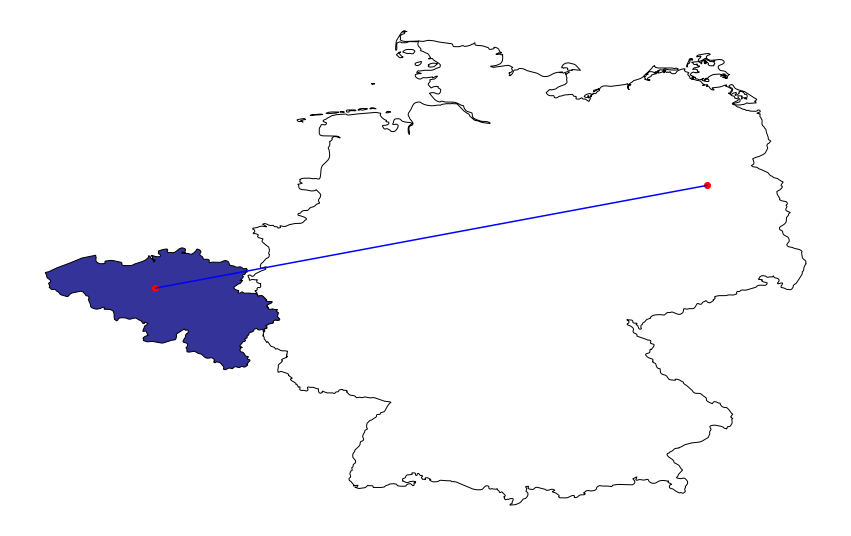

In [12]:
ax = gpd.GeoSeries([belgium, germany]).plot(cmap='terrain', figsize=(15,15), edgecolor='#000000')
gpd.GeoSeries([brussels, berlin]).plot(ax = ax, color='red')
gpd.GeoSeries([line]).plot(ax=ax, color='blue')
ax.set_axis_off()

## AMAZON INTERSECTING COUNTRIES

In [13]:
amazon = rivers.loc[rivers.name=='Amazonas', 'geometry'].squeeze()

In [14]:
amazon_ints = countries.loc[countries.intersects(amazon)]

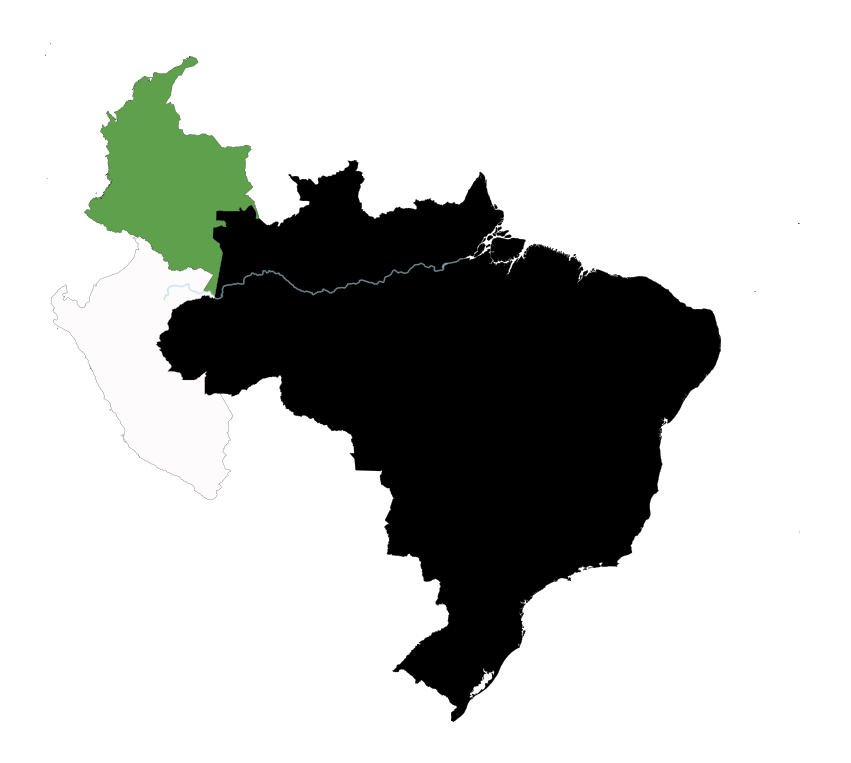

In [15]:
ax = amazon_ints.plot(cmap="gist_earth", edgecolor='#000000', linewidth=0.2, figsize=(15,15))
ax.set_axis_off()
gpd.GeoSeries([amazon]).plot(ax=ax, color="lightblue", alpha=.6)

## NILE INTERSECTING COUNTRIES

In [16]:
nile = rivers.loc[rivers.name=='Nile', 'geometry'].squeeze()

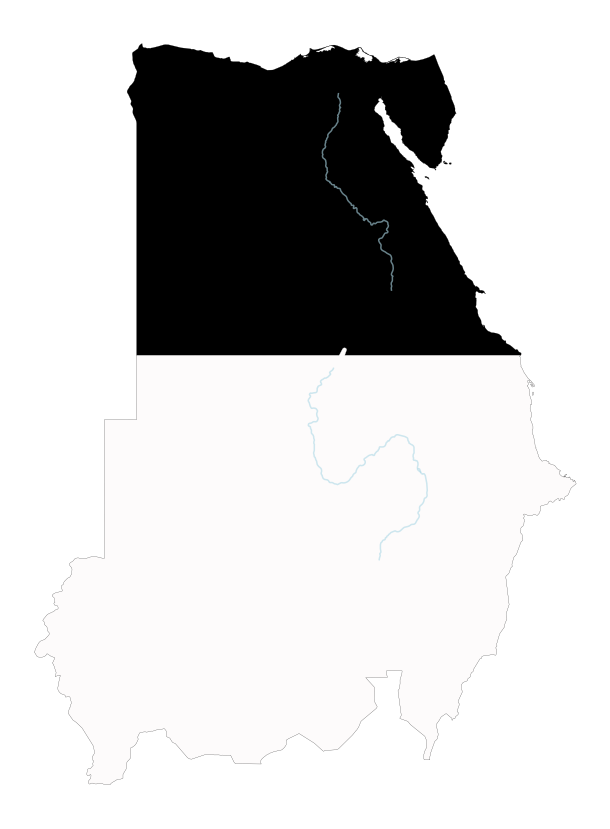

In [17]:
nile_ints = countries.loc[countries.intersects(nile)]
ax = nile_ints.plot(cmap="gist_earth", edgecolor="#000000", linewidth=.2, figsize=(15,15))
ax.set_axis_off()
gpd.GeoSeries([nile]).plot(ax=ax, alpha=.6, color="lightblue")

## COUNTRIES BORDERING BRAZIL

In [18]:
brazil = countries.loc[countries.name=="Brazil", 'geometry'].squeeze()
brazil_bordering = countries.loc[countries.touches(brazil)]

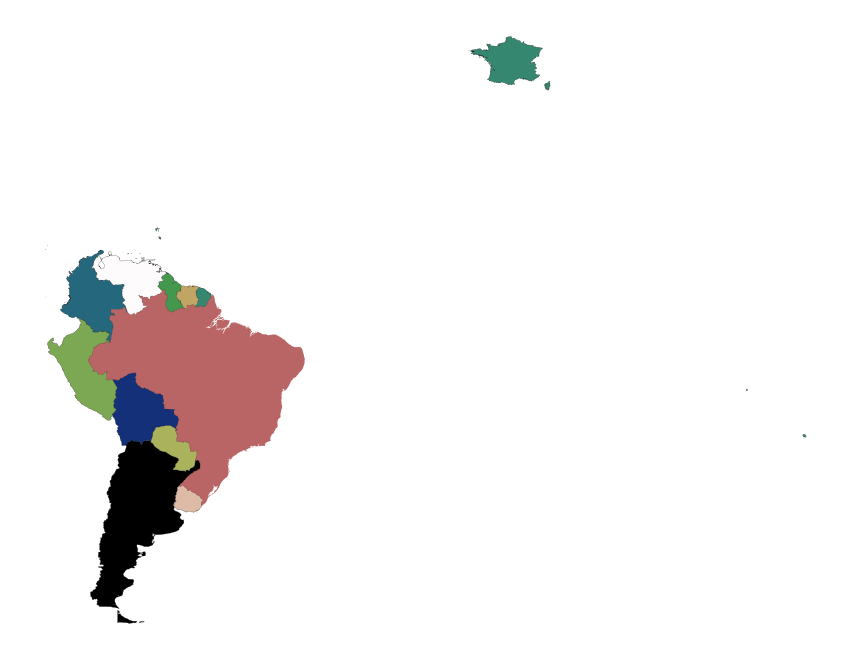

In [19]:
ax = brazil_bordering.plot(cmap="gist_earth", edgecolor='black', linewidth=0.2, figsize=(15,15))
ax.set_axis_off()
gpd.GeoSeries([brazil]).plot(ax=ax, alpha=.6, color="darkred")

## COUNTRIES BETWEEN BEIJING AND LISBON 

In [20]:
beijing = capitals.loc[capitals.name=='Beijing', 'geometry'].squeeze()
lisbon= capitals.loc[capitals.name=='Lisbon', 'geometry'].squeeze()

In [21]:
bc_line = LineString([beijing, lisbon])

In [22]:
bc_line_intersects = countries.loc[countries.intersects(bc_line)]

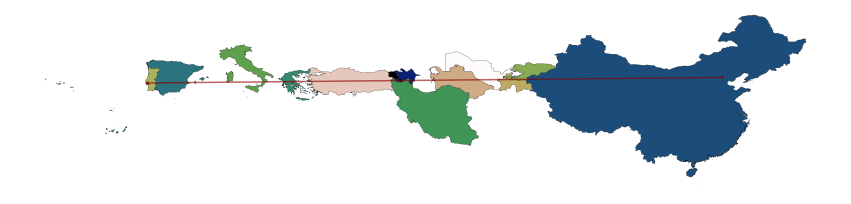

In [23]:
ax = bc_line_intersects.plot(cmap="gist_earth", edgecolor='black', linewidth=0.2, figsize=(15,15))
ax.set_axis_off()
gpd.GeoSeries([beijing, lisbon, bc_line]).plot(ax=ax, alpha=.6, color="darkred", markersize=5)

## COUNTRIES WITHIN 100km OF PARIS 

In [24]:
cities_km = cities.to_crs("EPSG:3035")

In [25]:
europe = countries[(countries.CONTINENT == 'Europe') & (countries.name != 'Russia')]
europe_km = europe.to_crs("EPSG:3035")

In [26]:
paris = cities_km.loc[(cities_km.name=='Paris') & (cities_km.iso_a2=='FR'), 'geometry'].squeeze()

In [27]:
num_kilometers = 1000 
paris_nk = paris.buffer(num_kilometers * 1000)

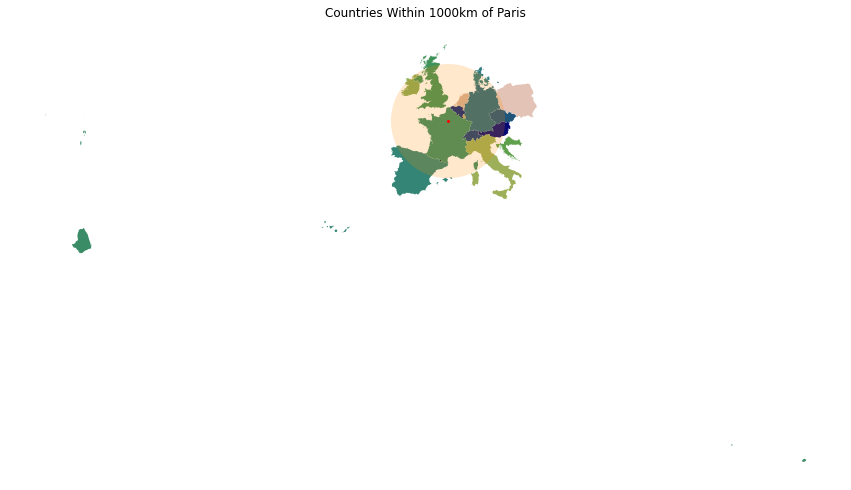

In [28]:
p_countries = europe_km.loc[europe_km.intersects(paris_nk)]
ax = p_countries.plot(cmap='gist_earth', figsize=(15,15))
ax.set_axis_off()
ax.set_title(f'Countries Within {num_kilometers}km of Paris')
gpd.GeoSeries([paris_nk]).plot(ax=ax, color='darkorange', alpha=.2)
gpd.GeoSeries([paris]).plot(ax=ax, color='red',markersize=4) 

In [29]:
import folium
paris = cities_km.loc[(cities_km.name=='Paris') & (cities_km.iso_a2=='FR'), 'geometry'].to_crs(epsg=4326)
paris=paris.squeeze()
osm_map = folium.Map(location=paris.coords[0][::-1], zoom_start=3)

folium.Circle(paris.coords[0][::-1], radius=1000*1000).add_to(osm_map)
folium.GeoJson(p_countries.to_crs(4326).to_json()).add_to(osm_map)
osm_map

## EXPLORING 2016 ELECTION

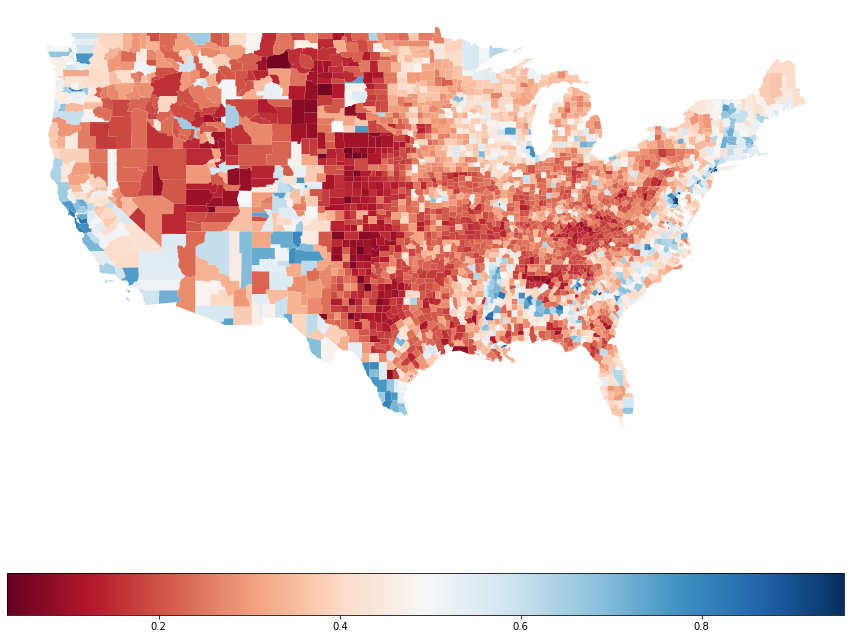

In [30]:
elec = gpd.read_file('zip://uspres.zip')

ax = elec.plot(column='dem_2016', figsize=(15,15), cmap="RdBu",legend=True, legend_kwds={'orientation': 'horizontal'})
ax.set_axis_off()

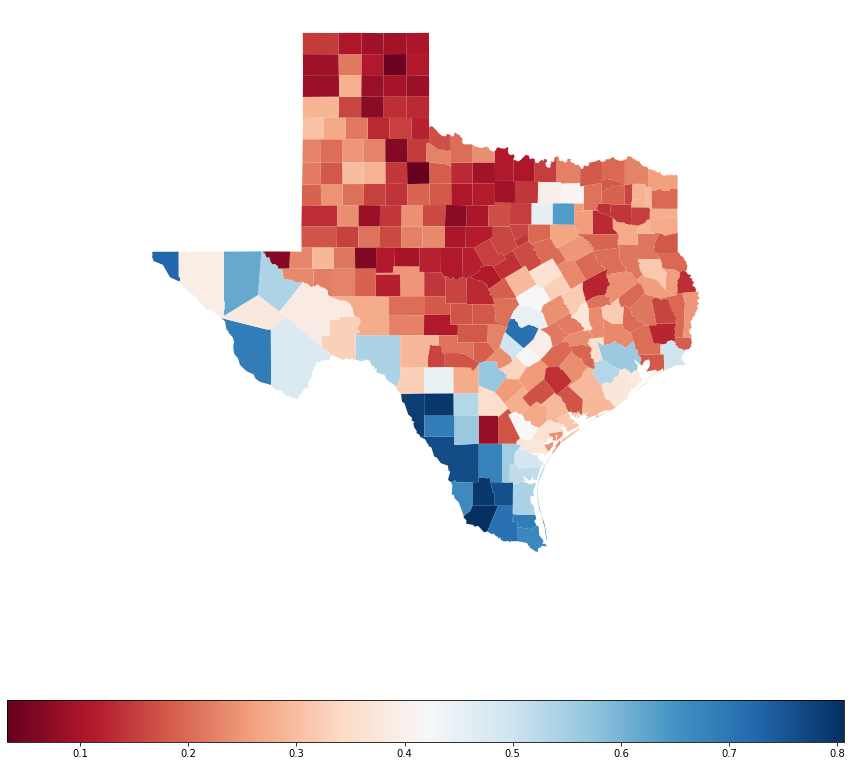

In [31]:
ax = elec.loc[elec.state_name=='Texas'].plot(column='dem_2016', figsize=(15,15), cmap="RdBu",legend=True, legend_kwds={'orientation': 'horizontal'})
ax.set_axis_off()

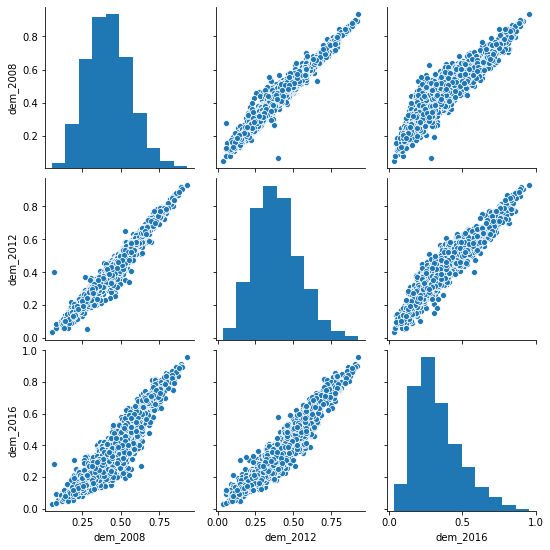

In [32]:
import seaborn as sns
elecs = sns.pairplot(data=elec.filter(like='dem_'))